## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [0]:
# File location and type
file_location = "/FileStore/tables/farm_ads.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "false"
delimiter = ","


# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df.printSchema()
df.show(10)


root
-- _c0: integer (nullable = true)
-- _c1: string (nullable = true)

+---+--------------------+
_c0| _c1|
+---+--------------------+
 1| ad-jerry ad-bruc...|
 -1| ad-rheumatoid ad...|
 -1| ad-rheumatologis...|
 -1| ad-siemen ad-wat...|
 -1| ad-symptom ad-mu...|
 1| ad-animal ad-ani...|
 -1| ad-dr ad-enrico ...|
 -1| ad-ulcerative ad...|
 -1| ad-wellcentive a...|
 1| ad-free ad-raw a...|
+---+--------------------+
only showing top 10 rows

In [0]:
# Change the column names
data = df.withColumnRenamed("_c0", "class").withColumnRenamed("_c1", "text")
data.show(5)

+-----+--------------------+
class| text|
+-----+--------------------+
 1| ad-jerry ad-bruc...|
 -1| ad-rheumatoid ad...|
 -1| ad-rheumatologis...|
 -1| ad-siemen ad-wat...|
 -1| ad-symptom ad-mu...|
+-----+--------------------+
only showing top 5 rows

In [0]:
# Count number of Words in each Text
from pyspark.sql.functions import length
data = data.withColumn('length', length(data['text']))
data.show(5)

+-----+--------------------+------+
class| text|length|
+-----+--------------------+------+
 1| ad-jerry ad-bruc...| 101|
 -1| ad-rheumatoid ad...| 3817|
 -1| ad-rheumatologis...| 657|
 -1| ad-siemen ad-wat...| 1317|
 -1| ad-symptom ad-mu...| 107|
+-----+--------------------+------+
only showing top 5 rows

In [0]:
# Compare the lenght difference between relevant and non-relevant
data.groupby('class').mean().show()

+-----+----------+------------------+
class|avg(class)| avg(length)|
+-----+----------+------------------+
 -1| -1.0|2919.4418003103983|
 1| 1.0| 3484.166968325792|
+-----+----------+------------------+

In [0]:
# Number of relevant and non-relevant
data.groupby('class').count().show()


+-----+-----+
class|count|
+-----+-----+
 -1| 1933|
 1| 2210|
+-----+-----+

In [0]:
from pyspark.sql import Row
display(data.groupBy('class').count())

class,count
-1,1933
1,2210


In [0]:
# Treat TF-IDF features for each text
# TF: Term Frequency
# IDF: Inverse Document Frequency
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler

# Tokenizer to split the text to words
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
# StopWordsRemover to filter out the stop words and the commonly used words including is, the
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
#Frequency (TF) of Word 
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
# Measure the IDF (Inverse Document Frequency) 
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
# Changing the labels in the class column to 0 for relevant ads and 1 for non-relevant ads.
class_num = StringIndexer(inputCol='class',outputCol='label')
final_feature = VectorAssembler(inputCols=['tf_idf', 'length'],outputCol='features')
 
from pyspark.ml import Pipeline
data_prep_pipe = Pipeline(stages=[class_num,tokenizer,stopremove,count_vec,idf,final_feature])
clean_data = data_prep_pipe.fit(data).transform(data)
 
clean_data.show(5)


+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
class| text|length|label| token_text| stop_tokens| c_vec| tf_idf| features|
+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
 1| ad-jerry ad-bruc...| 101| 0.0|[, ad-jerry, ad-b...|[, ad-jerry, ad-b...|(54858,[36,55,137...|(54858,[36,55,137...|(54859,[55,137,11...|
 -1| ad-rheumatoid ad...| 3817| 1.0|[, ad-rheumatoid,...|[, ad-rheumatoid,...|(54858,[0,2,3,6,7...|(54858,[0,2,3,6,7...|(54859,[0,2,3,6,7...|
 -1| ad-rheumatologis...| 657| 1.0|[, ad-rheumatolog...|[, ad-rheumatolog...|(54858,[3,7,36,61...|(54858,[3,7,36,61...|(54859,[3,7,61,65...|
 -1| ad-siemen ad-wat...| 1317| 1.0|[, ad-siemen, ad-...|[, ad-siemen, ad-...|(54858,[1,24,29,3...|(54858,[1,24,29,3...|(54859,[1,24,29,3...|
 -1| ad-symptom ad-mu...| 107| 1.0|[, ad-symptom, ad...|[, ad-symptom, ad...|(54858,[36,55,137...|(54858,[36,55,137...|(54859,[55,137,81...|
+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
# Selecting the first row of the data to check the elements
clean_data.first()

Out[70]: Row(class=1, text=' ad-jerry ad-bruckheimer ad-chase ad-premier ad-sept ad-th ad-clip ad-bruckheimer ad-chase page found', length=101, label=0.0, token_text=['', 'ad-jerry', 'ad-bruckheimer', 'ad-chase', 'ad-premier', 'ad-sept', 'ad-th', 'ad-clip', 'ad-bruckheimer', 'ad-chase', 'page', 'found'], stop_tokens=['', 'ad-jerry', 'ad-bruckheimer', 'ad-chase', 'ad-premier', 'ad-sept', 'ad-th', 'ad-clip', 'ad-bruckheimer', 'ad-chase', 'page', 'found'], c_vec=SparseVector(54858, {36: 1.0, 55: 1.0, 137: 1.0, 11599: 1.0, 12641: 1.0, 15674: 1.0, 19435: 2.0, 28298: 1.0, 30502: 2.0, 33117: 1.0}), tf_idf=SparseVector(54858, {36: 0.0, 55: 0.9473, 137: 1.2784, 11599: 5.9315, 12641: 6.25, 15674: 6.5377, 19435: 13.8862, 28298: 7.2308, 30502: 15.2725, 33117: 7.6363}), features=SparseVector(54859, {55: 0.9473, 137: 1.2784, 11599: 5.9315, 12641: 6.25, 15674: 6.5377, 19435: 13.8862, 28298: 7.2308, 30502: 15.2725, 33117: 7.6363, 54858: 101.0}))

In [0]:
# The last column i.e. the Features column from the first row to examine the Tf-IDf Matrix
clean_data.take(1)[0][-1]

Out[25]: SparseVector(54859, {55: 0.9473, 137: 1.2784, 11599: 5.9315, 12641: 6.25, 15674: 6.5377, 19435: 13.8862, 28298: 7.2308, 30502: 15.2725, 33117: 7.6363, 54858: 101.0})

In [0]:
from pyspark.sql.functions import col
import pyspark.sql.functions as PySparkFunc

# most frequent words in relevant ads
Relevant = clean_data.where(col("label") == 0).select(PySparkFunc.explode('token_text').alias('col')).groupBy('col').count().limit(10)

display(Relevant)



col,count
online,1688
electrical,262
inner,14
art,680
travel,447
hope,202
creativity,25
poppy,3
requirement,153
lixit,6


In [0]:
# most frequent words in relevant ads
non_Relevant = clean_data.where(col("label") == 1).select(PySparkFunc.explode('token_text').alias('col')).groupBy('col').count().limit(10)
display(non_Relevant)

col,count
everyday,354
online,722
electrical,61
inflammatory,484
transaction,26
barrier,39
recognize,119
somnodent,8
hope,239
cramp,95


In [0]:
#i.	Is it sparse matrix or dense matrix? (Or answer How much percentage of the entries in the matrix is zero?) 

# Calculating the Density and Sparsity of the Tf-IDf Feature Matrix

from numpy import count_nonzero

sparsity_data = (1.0 - count_nonzero(clean_data.take(1)[0][-1]) / clean_data.take(1)[0][-1].size)*100
print ("Sparsity is" ,round( sparsity_data,2),"%")

density_data = (count_nonzero(clean_data.take(1)[0][-1]) / clean_data.take(1)[0][-1].size)*100
print ("Density is" , round(density_data,2),"%")

# it is a sparse matrix as it is 99.98% sparsity

Sparsity is 99.98 %
Density is 0.02 %

In [0]:
## ii. Find two non-zero entries and briefly interpret their meaning, in words. (you do not need to derive their calculation)

#Several strategies outlined in this section can be used to convert text data directly into numbers:

#A. Term Frequency – Inverse Document Frequency (TF – IDF) Term Frequency – Inverse Document Frequency (TF – IDF) Term Frequency – Inverse

#The TF-IDF model is a weighted model used to solve information retrieval problems. Its aim is to translate text documents into vector models based on the appearance of terms in the documents rather than the exact sequence. Let's assume there's a dataset of N text documents, and each document "D" has TF and IDF identified as –

#Term Frequency (TF) – TF is defined as the number of times a term "t" appears in a document "D."

#IDF for a term is specified as the logarithm of the ratio of total documents available in the corpus to the number of documents containing the term T.

#As a result, TF-IDF means that words with a high frequency in the paper have a high TF, but if a word has a high frequency in the corpus, IDF reduces its value.The TF-IDF of a word that appears in all records in the corpus is 0.

# The concept is rarer the greater the numerical weight value. The word becomes more prominent as the weight decreases.
# So in result of "clean_data.take(1)[0][-1]"

#Out[45]: SparseVector(54859, {55: 0.9473, 136: 1.2784, 11294: 5.9315, 12593: 6.25, 15360: 6.5377, 20263: 13.8862, 25034: 15.2725, 32457: 7.2308, 53850: 7.6363, 54858: 101.0})

#Non-Zero entries are:	54: 0.9473     and.  	31835: 15.725

#This indicates that the word with feature 54 appears more often in our dataset than the word with feature 31835; the higher the TF-IDF score, the lower the frequency, and vice versa.

In [0]:
#b. Using logistic regression, partition the data (60% training, 40% validation), and develop a model to classify the documents as ‘relevant’ or ‘non-relevant.’ Comment on your model’s accuracy.

# ## Split data into training and test datasets
training, test = clean_data.randomSplit([0.6, 0.4], seed=12345)
print(training.count())
print(test.count())

2472
1671

In [0]:
# Build Logistic Regression Model
from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(featuresCol='features', labelCol='label')
model = log_reg.fit(training)

results = model.transform(test)


results.select('label','prediction').show(10)


+-----+----------+
label|prediction|
+-----+----------+
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
+-----+----------+
only showing top 10 rows

In [0]:
trainingSummary = model.summary
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+---+------------------+
FPR| TPR|
+---+------------------+
0.0| 0.0|
0.0|0.9471890971039182|
0.0|0.9531516183986372|
0.0| 0.954855195911414|
0.0|0.9557069846678024|
+---+------------------+
only showing top 5 rows

areaUnderROC: 0.9999967188414624

In [0]:
print("Coefficients: \n" + str(model.coefficientMatrix))
print("Intercept: " + str(model.interceptVector))


Coefficients: 
DenseMatrix([[-1.58885750e-03, -6.54797852e-03, 1.21205344e-02, ...,
 0.00000000e+00, 3.23838850e-01, -2.02449723e-05]])
Intercept: [-0.9478253162404922]

In [0]:
# Reset the DataFrames for number of relevant (`dfn`) and non-relevant(`dfy`)ads
dfn = training.filter(training.label == 0)
print("number of relevant ads in training dataset",dfn.count())
dfy = training.filter(training.label == 1)
print("number of non-relevant ads in training dataset",dfy.count())

number of relevant ads in training dataset 1298
number of non-relevant ads in training dataset 1174

In [0]:
display(training.groupBy('label').count())

label,count
0.0,1298
1.0,1174


In [0]:
# #### Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_true = results.select("label")
y_true = y_true.toPandas()

y_pred = results.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)

print(cnf_matrix)
print("Prediction Accuracy is ", (cnf_matrix[0,0]+cnf_matrix[1,1])/sum(sum(cnf_matrix)) )

[[818 94]
 [153 606]]
Prediction Accuracy is 0.8521843207660084

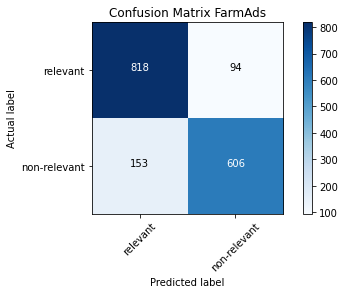

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cnf_matrix, title):
  # Clear Plot
  plt.gcf().clear()

  # Configure figure
  fig = plt.figure(1)
  
  # Configure plot
  classes = ['relevant', 'non-relevant']
  plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  # Normalize and establish threshold
  normalize=False
  fmt = 'd'
  thresh = cnf_matrix.max() / 2.

  # Iterate through the confusion matrix cells
  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j], fmt),
               horizontalalignment="center",
               color="white" if cnf_matrix[i, j] > thresh else "black")

  # Final plot configurations
  plt.tight_layout()
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label') 
  
  # Display images
  image = fig
  
  # Display Plot
  display(image)
  
  # Close Plot
  plt.close(fig)
  
  # Plot confusion matrix  
plot_confusion_matrix(cnf_matrix, "Confusion Matrix FarmAds")

In [0]:
#Comment on your model’s accuracy.
# GETTING THE CLASSIFICATION REPORT

classes = ['relevant', 'non-relevant']

print ('Classification Report:')

print(classification_report(y_true, y_pred, target_names = classes))

# It is 84% for the relevant ads and 87% for the non-relevant ads

Classification Report:
 precision recall f1-score support

 relevant 0.84 0.90 0.87 912
non-relevant 0.87 0.80 0.83 759

 accuracy 0.85 1671
 macro avg 0.85 0.85 0.85 1671
weighted avg 0.85 0.85 0.85 1671

In [0]:
#Comment on your model’s accuracy
# Model Evaluation

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error

evaluator = MulticlassClassificationEvaluator (labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(results)

print ("Test Accuracy = %g" %accuracy)

print("Test Error = %g" % (1.0 - accuracy))

#The model is 85.21% Accurate on testing data. 

Test Accuracy = 0.852184
Test Error = 0.147816

In [0]:
# View best model's predictions and probabilities of each prediction class
selected = results.select("label", "prediction", "probability", "text").limit(10)
display(selected)

label prediction probability text 1.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(3.841227669648814E-42, 1.0)) ad-adult ad-vaccination ad-eat ad-exercise ad-vaccinate ad-vaccine ad-location ad-near ad-www ad-helppreventdisease ad-com title-welcome title-helppreventdisease title-com header-prevention header-protection header-leave header-helppreventdisease header-com welcome helppreventdisease com root addthe utility frame root adult vaccination whoop cough hepatitis hepatitis cervical cancer influenza text size share print whoop cough prevention protection vaccine help prevention disease talk healthcare provider vaccine adult don realize immunity provide vaccine fade time adult vulnerable spread disease serious sometime fatal vaccine preventable disease cause adult death stay date recommend vaccination activity eate exercise stay healthy healthcare provider vaccine vaccination result protection vaccine recipient tool vaccination available near look stay date vaccination location vaccination available near select location select vaccine whoop cough hepatitis cervical cancer hepatitis influenza information center disease control prevention cdc cdc recommend adult vaccinate vaccine preventable disease cdc recommend vaccine adult recommend base person gender age risk factor click below access information cdc vaccination adult talk healthcare provider vaccine learn help prevent disease www helppreventwhoopingcough com www helppreventcervicalcancer com www helppreventhepatitis com www refusetheflu com website fund develop glaxosmithkline site intend resident glaxosmithkline reserve legal notice privacy statement medicine save contact leave helppreventdisease com link direct third party web site provide information vaccine preventable disease vaccination web site external glaxosmithkline glaxosmithkline control editorial otherwise content third party web site load 1.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(7.664796752367619E-50, 1.0)) ad-adult ad-vaccine ad-information ad-look ad-adult ad-vaccine ad-info ad-vaccination ad-www ad-helppreventdisease ad-com title-welcome title-helppreventdisease title-com header-prevention header-protection header-leave header-helppreventdisease header-com welcome helppreventdisease com root addthe utility frame root adult vaccination whoop cough hepatitis hepatitis cervical cancer influenza text size share print whoop cough prevention protection vaccine help prevention disease talk healthcare provider vaccine adult don realize immunity provide vaccine fade time adult vulnerable spread disease serious sometime fatal vaccine preventable disease cause adult death stay date recommend vaccination activity eate exercise stay healthy healthcare provider vaccine vaccination result protection vaccine recipient tool vaccination available near look stay date vaccination location vaccination available near select location select vaccine whoop cough hepatitis cervical cancer hepatitis influenza information center disease control prevention cdc cdc recommend adult vaccinate vaccine preventable disease cdc recommend vaccine adult recommend base person gender age risk factor click below access information cdc vaccination adult talk healthcare provider vaccine learn help prevent disease www helppreventwhoopingcough com www helppreventcervicalcancer com www helppreventhepatitis com www refusetheflu com website fund develop glaxosmithkline site intend resident glaxosmithkline reserve legal notice privacy statement medicine save contact leave helppreventdisease com link direct third party web site provide information vaccine preventable disease vaccination web site external glaxosmithkline glaxosmithkline control editorial otherwise content third party web site load 1.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(3.6939980159968135E-48, 1.0)) ad-alzheimer ad-treatment ad-free ad-john ad-hopkin ad-alzheimer ad-guide ad-america ad-hospital ad-free title-free title-john title-hopki

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
 
# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol='features', maxDepth=3)

 
# Train model with Training Data
dtModel = dt.fit(training)
display(dtModel)

treeNode
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":0.6383478673534981,""categories"":null,""feature"":18,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":0.868186124898441,""categories"":null,""feature"":39,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":0.9746471235197769,""categories"":null,""feature"":420,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":4.041940771155104,""categories"":null,""feature"":286,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":11,""featureType"":""continuous"",""prediction"":null,""threshold"":2.604558374695323,""categories"":null,""feature"":39,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":0.7897427950753746,""categories"":null,""feature"":9,""overflow"":false}"


In [0]:
predictionsdt = dtModel.transform(test)


# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionsdt)

print ("Test Accuracy for decision tree= %g" %accuracy)
print("Test Error for decision tree = %g " % (1.0 - accuracy))


Test Accuracy for decision tree= 0.75763
Test Error for decision tree = 0.24237